# Vamos a leer el cluster 1 y generar una predicción basado en los trabajos de Diana

vamos por paso
Vamos a ver si por memoria tengo que partir

En este caso no voy a generar las covariables que generó Daiana

Voy a probar que corra, si corre luego le agrego las variables y veo los cambios en Kaggle

Vamos a ver con CPU y llegado el caso pruebo con GPU




## Preparo todo

In [1]:
### me preparo en el entorno
# entorno
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    #FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    #DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    FUENTES_DIR = '/content/drive/MyDrive/MCD/Labo3/FUENTES/' # Ajustar según usuario
    DATOS_DIR = '/content/drive/MyDrive/MCD_grupo17_la_desgracia/lab3/PruebasAK/DATOSL3/' # ajustar según usuario OJO crear un acceso directo para poder "montar" una unidad compartida
else:
    # configuración para notebook con instalación LOCAL
    # FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = './DATOS/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


In [2]:
## Cargo lo necesario
# Cargo paquetes
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from numpy.polynomial import Polynomial
#from scipy.signal import detrend

#import itertools

import gc
from datetime import datetime

#import holidays

#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib')

In [3]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import KFold # Use KFold for regression
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
from lightgbm import early_stopping
import matplotlib.pyplot as plt
import os




In [4]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.8 MB/s eta 0:00:00


In [5]:
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

## Levanto el dataset
vamos a hacer el promedio de los últimos 12 meses por producto

In [6]:
# me traigo el archivo ya procesado con la duración completa
df_cluster_1 = pd.read_parquet(DATOS_DIR +'df_cluster1_full.parquet')
#df_cluster_3.head()
# productos a validar Son los que se van a estar vivos
productos_validar = pd.read_csv(DATOS_DIR +'product_id_apredecir201912.txt', sep='\t')
# me traigo el clasificador de clusters


In [7]:
# me quedo con las filas de df_cluster_3 cuyo product_id esté en productos_validar
###################################################
##### OJO, en realidad debo dejar todo
##### dejo las otras series que ayuden
##### saco de todo el conjunto lo que necesito al final
#############################
#df_cluster_X = df_cluster_3[df_cluster_3['product_id'].isin(productos_validar['product_id'])]
df_cluster_X = df_cluster_1.copy()
df_cluster_X.shape

(236511, 332)

In [8]:
## A partir de df_cluster_X quiero generar un df_historia que tenga indice, primera columna produc_cust_id segunda columna el mínimo valor distinto de cero para dicho product_cust_id
# Filtra las filas donde tn es distinto de cero
df_filtrado = df_cluster_X[df_cluster_X['tn'] != 0]

# Agrupa por product_cust_id y calcula el mínimo de tn (distinto de cero)
df_historia = (
    df_filtrado
    .groupby('product_cust_id', as_index=False)['tn']
    .min()
    .rename(columns={'tn': 'min'})
)

print(df_historia.head())

  product_cust_id    min
0     20001_10002  0.762
1     20001_10017  0.751
2     20001_10019  0.616
3     20001_10021  0.369
4     20001_10022  0.739


## comenzamos con LGBM

tomo las ideas y valores de DI

La estructura de Chat

Y cruzo los dedos


In [9]:
# Ordenar por product_cus_id y mes
df_cluster_X = df_cluster_X.sort_values(['product_cust_id', 'date_mes']).copy()

# Crear columna tn desplazada 2 meses adelante (tn_{t+2})
df_cluster_X['tn_shifted'] = (
    df_cluster_X.groupby('product_cust_id')['tn']
    .shift(-2)
)

# Crear target = tn_{t+2} - tn_{t}
df_cluster_X['target_diff'] = df_cluster_X['tn_shifted'] - df_cluster_X['tn']

In [10]:
# Crear columna 'pc_id' como producto de product_id * customer_id (int64)
df_cluster_X['pc_id'] = df_cluster_X['product_id'] * df_cluster_X['customer_id']

# Crear columna 'p_id' convirtiendo product_id a string
df_cluster_X['p_id'] = df_cluster_X['product_id'].astype(str)

# Crear columna 'c_id' convirtiendo customer_id a string
df_cluster_X['c_id'] = df_cluster_X['customer_id'].astype(str)

In [11]:
# Filtrar filas donde target_diff existe (meses 1 a 34)
df_model = df_cluster_X[df_cluster_X['target_diff'].notnull()].copy()

In [ ]:
df_model.shape

(221483, 337)

In [12]:
# me guardo copia del modelo, por las dudas
df_model_backup = df_model.copy()

In [13]:
# ----- Paso 1: Definir columnas -----

# Variables categóricas (tipo object o category), excluyendo product_cus_id
categorical_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()
if 'product_cust_id' in categorical_cols:
    categorical_cols.remove('product_cust_id')
if 'p_id' in categorical_cols:
    categorical_cols.remove('p_id')
if 'c_id' in categorical_cols:
    categorical_cols.remove('c_id')


# Variable objetivo e IDs a excluir de features
exclude_cols = ['target_diff', 'tn', 'tn_shifted', 'product_cust_id', 'date_mes']

# Variables numéricas (excluyendo categóricas y columnas a excluir)
num_cols = [
    c for c in df_model.columns
    if c not in categorical_cols + exclude_cols and np.issubdtype(df_model[c].dtype, np.number)
]

In [14]:
scalers = {}

for col in num_cols:
    col_data = df_model[col]
    std = col_data.std()
    mean = col_data.mean()

    if std > 0:
        df_model[col] = col_data / std
        scalers[col] = ('std', std)
    elif mean > 0:
        df_model[col] = col_data / mean
        scalers[col] = ('mean', mean)
    else:
        # No se escala si std=0 y mean=0
        scalers[col] = ('none', None)

In [ ]:
## dejo por si hace falta luego escalar por serie: OJO menos valores más inestable. pero captura mejor los detalles
def normalize_group(df, cols):
    df_norm = df.copy()
    for col in cols:
        def scale_func(x):
            std = x.std()
            mean = x.mean()
            if std > 0:
                return x / std
            elif mean > 0:
                return x / mean
            else:
                return x
        df_norm[col] = df.groupby('product_cus_id')[col].transform(scale_func)
    return df_norm

#df_model_norm = normalize_group(df_model, num_cols)

In [15]:
# ----- Paso 3: Label Encoding para categóricas -----

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    vals = df_model[col].astype(str).fillna('missing')
    df_model[col] = le.fit_transform(vals)
    le_dict[col] = le

In [16]:
df_model.head()

,customer_id,product_id,date_mes,first_customer_date,last_customer_date,first_product_date,last_product_date,tn,dif_tn,dif_por,vida_prod,vida_customer,meses_on,meses_off,vida_restante,anio,mes,secuencia,trimestre,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,periodo,stock_final,dias_laborables_arg,cisne_negro,VtaGral,VtaGralCte,Bebidas,Almacen,Panaderia,Lacteos,Carnes,Verduleria_y_fruteria,Articulos_de_limpieza_y_perfumeria,Indumentaria_calzado_y_textiles_para_el_hogar,Electronicos_y_articulos_para_el_hogar,Otros,USD_of,USD_blue,Infl,Expect,product_cust_id,tn_sum_cus,tn_sum_cus_rolling_3m,tn_sum_cus_rolling_3m_min,tn_sum_cus_rolling_3m_max,tn_sum_cus_rolling_3m_std,tn_sum_cus_rolling_6m,tn_sum_cus_rolling_6m_min,tn_sum_cus_rolling_6m_max,tn_sum_cus_rolling_6m_std,tn_sum_cus_rolling_9m,tn_sum_cus_rolling_9m_min,tn_sum_cus_rolling_9m_max,tn_sum_cus_rolling_9m_std,tn_sum_cus_rolling_12m,tn_sum_cus_rolling_12m_min,tn_sum_cus_rolling_12m_max,tn_sum_cus_rolling_12m_std,tn_sum_cus_lag_3m,tn_sum_cus_lag_3m_min,tn_sum_cus_lag_3m_max,tn_sum_cus_lag_3m_std,tn_sum_cus_lag_6m,tn_sum_cus_lag_6m_min,tn_sum_cus_lag_6m_max,tn_sum_cus_lag_6m_std,tn_sum_cus_lag_9m,tn_sum_cus_lag_9m_min,tn_sum_cus_lag_9m_max,tn_sum_cus_lag_9m_std,tn_sum_cus_lag_12m,tn_sum_cus_lag_12m_min,tn_sum_cus_lag_12m_max,tn_sum_cus_lag_12m_std,delta_rolling_3m,delta_rolling_3m_min,delta_rolling_3m_max,delta_rolling_3m_std,delta_rolling_6m,delta_rolling_6m_min,delta_rolling_6m_max,delta_rolling_6m_std,delta_rolling_9m,delta_rolling_9m_min,delta_rolling_9m_max,delta_rolling_9m_std,delta_rolling_12m,delta_rolling_12m_min,delta_rolling_12m_max,delta_rolling_12m_std,delta_lag_3m,delta_lag_3m_min,delta_lag_3m_max,delta_lag_3m_std,delta_lag_6m,delta_lag_6m_min,delta_lag_6m_max,delta_lag_6m_std,delta_lag_9m,delta_lag_9m_min,delta_lag_9m_max,delta_lag_9m_std,delta_lag_12m,delta_lag_12m_min,delta_lag_12m_max,delta_lag_12m_std,tn_sum_cus_min,tn_sum_cus_max,tn_sum_cus_std,tn_sum_prod,tn_sum_prod_rolling_3m,tn_sum_prod_rolling_3m_min,tn_sum_prod_rolling_3m_max,tn_sum_prod_rolling_3m_std,tn_sum_prod_rolling_6m,tn_sum_prod_rolling_6m_min,tn_sum_prod_rolling_6m_max,tn_sum_prod_rolling_6m_std,tn_sum_prod_rolling_9m,tn_sum_prod_rolling_9m_min,tn_sum_prod_rolling_9m_max,tn_sum_prod_rolling_9m_std,tn_sum_prod_rolling_12m,tn_sum_prod_rolling_12m_min,tn_sum_prod_rolling_12m_max,tn_sum_prod_rolling_12m_std,tn_sum_prod_lag_3m,tn_sum_prod_lag_3m_min,tn_sum_prod_lag_3m_max,tn_sum_prod_lag_3m_std,tn_sum_prod_lag_6m,tn_sum_prod_lag_6m_min,tn_sum_prod_lag_6m_max,tn_sum_prod_lag_6m_std,tn_sum_prod_lag_9m,tn_sum_prod_lag_9m_min,tn_sum_prod_lag_9m_max,tn_sum_prod_lag_9m_std,tn_sum_prod_lag_12m,tn_sum_prod_lag_12m_min,tn_sum_prod_lag_12m_max,tn_sum_prod_lag_12m_std,delta_rolling_3m_prod,delta_rolling_3m_min_prod,delta_rolling_3m_max_prod,delta_rolling_3m_std_prod,delta_rolling_6m_prod,delta_rolling_6m_min_prod,delta_rolling_6m_max_prod,delta_rolling_6m_std_prod,delta_rolling_9m_prod,delta_rolling_9m_min_prod,delta_rolling_9m_max_prod,delta_rolling_9m_std_prod,delta_rolling_12m_prod,delta_rolling_12m_min_prod,delta_rolling_12m_max_prod,delta_rolling_12m_std_prod,delta_lag_3m_prod,delta_lag_3m_min_prod,delta_lag_3m_max_prod,delta_lag_3m_std_prod,delta_lag_6m_prod,delta_lag_6m_min_prod,delta_lag_6m_max_prod,delta_lag_6m_std_prod,delta_lag_9m_prod,delta_lag_9m_min_prod,delta_lag_9m_max_prod,delta_lag_9m_std_prod,delta_lag_12m_prod,delta_lag_12m_min_prod,delta_lag_12m_max_prod,delta_lag_12m_std_prod,tn_sum_prod_min,tn_sum_prod_max,tn_sum_prod_std,tn_lag1,tn_lag2,tn_lag3,tn_lag4,tn_lag5,tn_lag6,tn_lag7,tn_lag8,tn_lag9,tn_lag10,tn_lag11,tn_lag12,tn_mean_3m,tn_min_3m,tn_max_3m,tn_std_3m,tn_trend_3m,tn_meses_desde_max_3m,tn_mean_6m,tn_min_6m,tn_max_6m,tn_std_6m,tn_trend_6m,tn_meses_desde_max_6m,tn_mean_9m,tn_min_9m,tn_max_9m,tn_std_9m,tn_trend_9m,tn_meses_desde_max_9m,tn_mean_12m,tn_min_12m,tn_max_12m,tn_std_12m,tn_trend_12m,tn_meses_desde_max_12m,tn_cat1_cus_mes,tn_cat1_cat2_cus_mes,

In [17]:
# ----- Paso 4: Prep X, y -----

X = df_model[num_cols + categorical_cols]
y = df_model['target_diff'].values


In [18]:
# ----- Paso 5: Función objetivo Optuna con 5-Fold CV -----

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mse', # dejo MSE por el problema
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': 42,
        'num_leaves': trial.suggest_int('num_leaves', 10, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 40, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols, free_raw_data=False)
        lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train, categorical_feature=categorical_cols, free_raw_data=False)
        gbm = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_val],
            num_boost_round=1000,
            callbacks=[early_stopping(stopping_rounds=50)],
            #verbose_eval=False
        )
        preds = gbm.predict(X_val, num_iteration=gbm.best_iteration)
        mse = mean_squared_error(y_val, preds)
        rmse = np.sqrt(mse)
        rmses.append(rmse)

    return np.mean(rmses)

In [ ]:
# si tengo los resultados guardados me puedo saltar este paso
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Mejor RMSE promedio en CV: {study.best_value:.6f}')
print(f'Mejor parámetros: {study.best_params}')

[I 2025-07-20 05:18:09,366] A new study created in memory with name: no-name-6369fd0d-feef-4b28-b128-6d0400d158b5
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uni

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[191]	valid_0's l2: 3.62669
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[240]	valid_0's l2: 5.8279
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's l2: 5.00125
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[363]	valid_0's l2: 6.53062
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:18:55,473] Trial 0 finished with value: 2.2999692721783136 and parameters: {'num_leaves': 124, 'max_depth': 3, 'learning_rate': 0.06835760104838878, 'feature_fraction': 0.6801083547891018, 'bagging_fraction': 0.8775936603939105, 'bagging_freq': 2, 'min_data_in_leaf': 83, 'lambda_l1': 1.0009754476798483, 'lambda_l2': 0.0043612172014648514}. Best is trial 0 with value: 2.2999692721783136.


Early stopping, best iteration is:
[320]	valid_0's l2: 5.70972


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[710]	valid_0's l2: 3.64528
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[656]	valid_0's l2: 5.75919
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[922]	valid_0's l2: 5.09364
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 6.5839
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[985]	valid_0's l2: 5.77972


[I 2025-07-20 05:20:35,427] Trial 1 finished with value: 2.307203663609382 and parameters: {'num_leaves': 234, 'max_depth': 4, 'learning_rate': 0.010959649412051464, 'feature_fraction': 0.7416184798131422, 'bagging_fraction': 0.8079635023024226, 'bagging_freq': 2, 'min_data_in_leaf': 64, 'lambda_l1': 1.906319454875705e-07, 'lambda_l2': 2.280297387257372e-05}. Best is trial 0 with value: 2.2999692721783136.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[252]	valid_0's l2: 3.51233
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's l2: 5.62539
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's l2: 5.31472
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[334]	valid_0's l2: 6.79369
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[856]	valid_0's l2: 5.41531


[I 2025-07-20 05:22:02,355] Trial 2 finished with value: 2.2969665222460924 and parameters: {'num_leaves': 207, 'max_depth': 14, 'learning_rate': 0.034409168961641576, 'feature_fraction': 0.5560747353430475, 'bagging_fraction': 0.6230393748906206, 'bagging_freq': 2, 'min_data_in_leaf': 79, 'lambda_l1': 2.51307536835861e-05, 'lambda_l2': 7.186528335975104e-08}. Best is trial 2 with value: 2.2969665222460924.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[255]	valid_0's l2: 3.58579
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[246]	valid_0's l2: 5.65382
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[255]	valid_0's l2: 5.10978
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[311]	valid_0's l2: 6.53816
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[360]	valid_0's l2: 5.49473


[I 2025-07-20 05:23:29,289] Trial 3 finished with value: 2.2865889847770986 and parameters: {'num_leaves': 149, 'max_depth': 14, 'learning_rate': 0.034845600582163114, 'feature_fraction': 0.6887339825588792, 'bagging_fraction': 0.9713168768992873, 'bagging_freq': 3, 'min_data_in_leaf': 68, 'lambda_l1': 0.41716306346541204, 'lambda_l2': 0.9833912735219672}. Best is trial 3 with value: 2.2865889847770986.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	valid_0's l2: 3.6928
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[336]	valid_0's l2: 5.72871
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[303]	valid_0's l2: 5.10474
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[382]	valid_0's l2: 6.58813
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:24:09,969] Trial 4 finished with value: 2.3116246828217997 and parameters: {'num_leaves': 226, 'max_depth': 3, 'learning_rate': 0.043171064705374344, 'feature_fraction': 0.6088502371167619, 'bagging_fraction': 0.8468289496793733, 'bagging_freq': 6, 'min_data_in_leaf': 83, 'lambda_l1': 0.002000064560431807, 'lambda_l2': 0.06983057806547514}. Best is trial 3 with value: 2.2865889847770986.


Early stopping, best iteration is:
[221]	valid_0's l2: 5.84131


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[366]	valid_0's l2: 3.55955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[401]	valid_0's l2: 5.68908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[387]	valid_0's l2: 5.21704
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[299]	valid_0's l2: 6.71436
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[540]	valid_0's l2: 5.63847


[I 2025-07-20 05:25:56,200] Trial 5 finished with value: 2.3043392729077823 and parameters: {'num_leaves': 41, 'max_depth': 19, 'learning_rate': 0.02289302635622723, 'feature_fraction': 0.7351999053573874, 'bagging_fraction': 0.9554148193047166, 'bagging_freq': 5, 'min_data_in_leaf': 98, 'lambda_l1': 0.00012348347806160422, 'lambda_l2': 7.334704865942074e-08}. Best is trial 3 with value: 2.2865889847770986.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	valid_0's l2: 3.54814
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	valid_0's l2: 5.69867
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's l2: 5.15126
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[131]	valid_0's l2: 6.72122
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:26:33,746] Trial 6 finished with value: 2.2978088515386212 and parameters: {'num_leaves': 127, 'max_depth': 8, 'learning_rate': 0.08715348273677423, 'feature_fraction': 0.7507915954023077, 'bagging_fraction': 0.7622881149282366, 'bagging_freq': 6, 'min_data_in_leaf': 69, 'lambda_l1': 7.609676241859904e-07, 'lambda_l2': 6.400829705550999e-08}. Best is trial 3 with value: 2.2865889847770986.


Early stopping, best iteration is:
[210]	valid_0's l2: 5.5509


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	valid_0's l2: 3.67542
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[171]	valid_0's l2: 5.64765
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's l2: 5.32114
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[295]	valid_0's l2: 6.59154
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:27:08,030] Trial 7 finished with value: 2.304765243564003 and parameters: {'num_leaves': 167, 'max_depth': 5, 'learning_rate': 0.09707318045980746, 'feature_fraction': 0.536547406243193, 'bagging_fraction': 0.82400578889969, 'bagging_freq': 1, 'min_data_in_leaf': 80, 'lambda_l1': 4.083102531579366e-05, 'lambda_l2': 3.1845548036524044e-05}. Best is trial 3 with value: 2.2865889847770986.


Early stopping, best iteration is:
[147]	valid_0's l2: 5.55097


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's l2: 3.69013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's l2: 5.78663
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's l2: 5.16826
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	valid_0's l2: 6.76351
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:27:42,916] Trial 8 finished with value: 2.321233333574806 and parameters: {'num_leaves': 112, 'max_depth': 11, 'learning_rate': 0.19478744506876833, 'feature_fraction': 0.6781642575946358, 'bagging_fraction': 0.8675529384305946, 'bagging_freq': 1, 'min_data_in_leaf': 98, 'lambda_l1': 8.63858543103218, 'lambda_l2': 0.028254403831026842}. Best is trial 3 with value: 2.2865889847770986.


Early stopping, best iteration is:
[95]	valid_0's l2: 5.78692


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[648]	valid_0's l2: 3.60459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[395]	valid_0's l2: 5.73017
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[328]	valid_0's l2: 5.22713
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[420]	valid_0's l2: 6.81307
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[648]	valid_0's l2: 5.68504


[I 2025-07-20 05:29:11,896] Trial 9 finished with value: 2.314632930734069 and parameters: {'num_leaves': 233, 'max_depth': 6, 'learning_rate': 0.013998729859178967, 'feature_fraction': 0.9538661765559566, 'bagging_fraction': 0.7937762727695934, 'bagging_freq': 4, 'min_data_in_leaf': 42, 'lambda_l1': 4.9502414574882644e-05, 'lambda_l2': 9.936948321901744e-07}. Best is trial 3 with value: 2.2865889847770986.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[338]	valid_0's l2: 3.54323
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[285]	valid_0's l2: 5.54324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[342]	valid_0's l2: 5.18628
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[316]	valid_0's l2: 6.83269
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[406]	valid_0's l2: 5.57693


[I 2025-07-20 05:31:10,971] Trial 10 finished with value: 2.297917795370799 and parameters: {'num_leaves': 69, 'max_depth': 17, 'learning_rate': 0.024749731430248025, 'feature_fraction': 0.8745064729679242, 'bagging_fraction': 0.995633772512993, 'bagging_freq': 4, 'min_data_in_leaf': 52, 'lambda_l1': 0.022554686532639166, 'lambda_l2': 0.6649777901598998}. Best is trial 3 with value: 2.2865889847770986.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feat

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[260]	valid_0's l2: 3.48767
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[211]	valid_0's l2: 5.50011
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[285]	valid_0's l2: 5.221
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[122]	valid_0's l2: 6.72907
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[474]	valid_0's l2: 5.4781


[I 2025-07-20 05:32:13,160] Trial 11 finished with value: 2.2864580404518566 and parameters: {'num_leaves': 177, 'max_depth': 14, 'learning_rate': 0.040653715777440466, 'feature_fraction': 0.5111166386804813, 'bagging_fraction': 0.6098751644434159, 'bagging_freq': 3, 'min_data_in_leaf': 61, 'lambda_l1': 0.054556773432149645, 'lambda_l2': 6.598362475157247}. Best is trial 11 with value: 2.2864580404518566.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's l2: 3.51052
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's l2: 5.6974
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[138]	valid_0's l2: 5.26625
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's l2: 6.92058
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	valid_0's l2: 5.59254


[I 2025-07-20 05:32:56,663] Trial 12 finished with value: 2.3101891445931058 and parameters: {'num_leaves': 175, 'max_depth': 14, 'learning_rate': 0.058101083402509676, 'feature_fraction': 0.503193661572104, 'bagging_fraction': 0.6586663949385271, 'bagging_freq': 3, 'min_data_in_leaf': 58, 'lambda_l1': 0.10451071837389077, 'lambda_l2': 8.00888022244278}. Best is trial 11 with value: 2.2864580404518566.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feat

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[260]	valid_0's l2: 3.56659
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[296]	valid_0's l2: 5.66114
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[324]	valid_0's l2: 5.04491
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[159]	valid_0's l2: 6.87898
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[661]	valid_0's l2: 5.43251


[I 2025-07-20 05:34:35,150] Trial 13 finished with value: 2.2935001019253485 and parameters: {'num_leaves': 170, 'max_depth': 12, 'learning_rate': 0.02538598448589418, 'feature_fraction': 0.8518056948094529, 'bagging_fraction': 0.7146316584654281, 'bagging_freq': 3, 'min_data_in_leaf': 52, 'lambda_l1': 0.02245635615302554, 'lambda_l2': 7.150557669682971}. Best is trial 11 with value: 2.2864580404518566.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	valid_0's l2: 3.59677
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[194]	valid_0's l2: 5.58581
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[201]	valid_0's l2: 5.18107
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[295]	valid_0's l2: 6.62589
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[212]	valid_0's l2: 5.68605


[I 2025-07-20 05:35:41,943] Trial 14 finished with value: 2.2989533276937295 and parameters: {'num_leaves': 91, 'max_depth': 16, 'learning_rate': 0.04153918044462906, 'feature_fraction': 0.6124388128425508, 'bagging_fraction': 0.9214361623805771, 'bagging_freq': 4, 'min_data_in_leaf': 72, 'lambda_l1': 0.45297440876814843, 'lambda_l2': 0.32463925524112525}. Best is trial 11 with value: 2.2864580404518566.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's l2: 3.56974
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[162]	valid_0's l2: 5.69045
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	valid_0's l2: 5.30684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	valid_0's l2: 6.78718
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:36:19,286] Trial 15 finished with value: 2.314940089370572 and parameters: {'num_leaves': 196, 'max_depth': 9, 'learning_rate': 0.11649212121383039, 'feature_fraction': 0.8257012521461831, 'bagging_fraction': 0.7122511945349959, 'bagging_freq': 3, 'min_data_in_leaf': 61, 'lambda_l1': 0.003982521202774009, 'lambda_l2': 0.0029646744314314635}. Best is trial 11 with value: 2.2864580404518566.


Early stopping, best iteration is:
[222]	valid_0's l2: 5.71678


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[273]	valid_0's l2: 3.52653
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[245]	valid_0's l2: 5.59155
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[315]	valid_0's l2: 5.13997
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[246]	valid_0's l2: 6.75102
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[266]	valid_0's l2: 5.77562


[I 2025-07-20 05:37:40,853] Trial 16 finished with value: 2.302245194326346 and parameters: {'num_leaves': 155, 'max_depth': 14, 'learning_rate': 0.016612846561764646, 'feature_fraction': 0.607228796806411, 'bagging_fraction': 0.6179300477382516, 'bagging_freq': 7, 'min_data_in_leaf': 45, 'lambda_l1': 2.171834242432141, 'lambda_l2': 1.5812116720537122}. Best is trial 11 with value: 2.2864580404518566.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('featu

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[185]	valid_0's l2: 3.62495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[179]	valid_0's l2: 5.82132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[255]	valid_0's l2: 5.28432
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[365]	valid_0's l2: 6.88913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[665]	valid_0's l2: 5.45611


[I 2025-07-20 05:39:03,624] Trial 17 finished with value: 2.315196360446662 and parameters: {'num_leaves': 24, 'max_depth': 20, 'learning_rate': 0.03243718761160365, 'feature_fraction': 0.9799274287564677, 'bagging_fraction': 0.7280930442480374, 'bagging_freq': 5, 'min_data_in_leaf': 73, 'lambda_l1': 0.0015836140491292, 'lambda_l2': 0.001229027491256891}. Best is trial 11 with value: 2.2864580404518566.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[178]	valid_0's l2: 3.53323
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[159]	valid_0's l2: 5.52083
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[172]	valid_0's l2: 5.33797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[402]	valid_0's l2: 6.72292
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[461]	valid_0's l2: 5.5138


[I 2025-07-20 05:40:25,053] Trial 18 finished with value: 2.2961490028428235 and parameters: {'num_leaves': 147, 'max_depth': 17, 'learning_rate': 0.05532481435190747, 'feature_fraction': 0.6558158216711089, 'bagging_fraction': 0.9997227654115046, 'bagging_freq': 3, 'min_data_in_leaf': 90, 'lambda_l1': 0.09548651025471828, 'lambda_l2': 0.06027726183728378}. Best is trial 11 with value: 2.2864580404518566.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[190]	valid_0's l2: 3.79449
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[341]	valid_0's l2: 5.5964
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's l2: 5.31129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[302]	valid_0's l2: 6.79346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[475]	valid_0's l2: 5.67296


[I 2025-07-20 05:41:46,463] Trial 19 finished with value: 2.321292865973776 and parameters: {'num_leaves': 190, 'max_depth': 11, 'learning_rate': 0.016635853954930075, 'feature_fraction': 0.8016474705236252, 'bagging_fraction': 0.6625333587264071, 'bagging_freq': 5, 'min_data_in_leaf': 54, 'lambda_l1': 1.4889343430808597e-08, 'lambda_l2': 0.0001227392874999374}. Best is trial 11 with value: 2.2864580404518566.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifo

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's l2: 3.665
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's l2: 5.66385
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	valid_0's l2: 5.30828
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	valid_0's l2: 6.52365
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:42:31,114] Trial 20 finished with value: 2.2991318719986586 and parameters: {'num_leaves': 252, 'max_depth': 13, 'learning_rate': 0.15764721342563887, 'feature_fraction': 0.8984146008141827, 'bagging_fraction': 0.925616936953613, 'bagging_freq': 2, 'min_data_in_leaf': 65, 'lambda_l1': 0.16106462724537335, 'lambda_l2': 1.0267637115866892}. Best is trial 11 with value: 2.2864580404518566.


Early stopping, best iteration is:
[107]	valid_0's l2: 5.49078


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[335]	valid_0's l2: 3.50541
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[267]	valid_0's l2: 5.60752
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[324]	valid_0's l2: 5.11981
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[126]	valid_0's l2: 6.821
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[316]	valid_0's l2: 5.62414


[I 2025-07-20 05:43:47,983] Trial 21 finished with value: 2.2972445382532443 and parameters: {'num_leaves': 149, 'max_depth': 12, 'learning_rate': 0.025541882418496514, 'feature_fraction': 0.8217993342961392, 'bagging_fraction': 0.6882236012353011, 'bagging_freq': 3, 'min_data_in_leaf': 49, 'lambda_l1': 0.013616947083567851, 'lambda_l2': 9.143708903334101}. Best is trial 11 with value: 2.2864580404518566.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[261]	valid_0's l2: 3.59472
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[315]	valid_0's l2: 5.69593
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[318]	valid_0's l2: 5.08609
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[145]	valid_0's l2: 6.79284
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[482]	valid_0's l2: 5.55617


[I 2025-07-20 05:44:57,235] Trial 22 finished with value: 2.3002575443015165 and parameters: {'num_leaves': 175, 'max_depth': 9, 'learning_rate': 0.031776336035591414, 'feature_fraction': 0.9036608264588111, 'bagging_fraction': 0.7504148449946485, 'bagging_freq': 3, 'min_data_in_leaf': 59, 'lambda_l1': 0.047739538331975674, 'lambda_l2': 7.965190043726297}. Best is trial 11 with value: 2.2864580404518566.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[364]	valid_0's l2: 3.64297
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[271]	valid_0's l2: 5.66324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[380]	valid_0's l2: 5.22767
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[296]	valid_0's l2: 6.84932
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[640]	valid_0's l2: 5.51021


[I 2025-07-20 05:46:41,219] Trial 23 finished with value: 2.3078656001761706 and parameters: {'num_leaves': 99, 'max_depth': 16, 'learning_rate': 0.019473703431225505, 'feature_fraction': 0.7857622345322891, 'bagging_fraction': 0.6066195480575667, 'bagging_freq': 4, 'min_data_in_leaf': 53, 'lambda_l1': 0.00048473347593990467, 'lambda_l2': 0.20040361044476548}. Best is trial 11 with value: 2.2864580404518566.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[254]	valid_0's l2: 3.56635
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[135]	valid_0's l2: 5.64065
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's l2: 5.31886
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	valid_0's l2: 6.87428
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[316]	valid_0's l2: 5.44417


[I 2025-07-20 05:47:37,061] Trial 24 finished with value: 2.3049818247107954 and parameters: {'num_leaves': 198, 'max_depth': 12, 'learning_rate': 0.05456761928508331, 'feature_fraction': 0.8603170623225902, 'bagging_fraction': 0.6512353016620249, 'bagging_freq': 2, 'min_data_in_leaf': 67, 'lambda_l1': 6.239627103874367, 'lambda_l2': 0.016571109161046295}. Best is trial 11 with value: 2.2864580404518566.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[261]	valid_0's l2: 3.48677
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[197]	valid_0's l2: 5.6804
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	valid_0's l2: 5.16953
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[190]	valid_0's l2: 6.74466
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[273]	valid_0's l2: 5.6944


[I 2025-07-20 05:48:53,472] Trial 25 finished with value: 2.301530168417539 and parameters: {'num_leaves': 135, 'max_depth': 15, 'learning_rate': 0.03680813779751852, 'feature_fraction': 0.9418263552806045, 'bagging_fraction': 0.696573221966111, 'bagging_freq': 3, 'min_data_in_leaf': 46, 'lambda_l1': 0.006645995386194998, 'lambda_l2': 1.9635577514622653}. Best is trial 11 with value: 2.2864580404518566.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[364]	valid_0's l2: 3.60237
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[272]	valid_0's l2: 5.60395
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid_0's l2: 5.05963
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[412]	valid_0's l2: 6.66179
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[448]	valid_0's l2: 5.55263


[I 2025-07-20 05:50:10,477] Trial 26 finished with value: 2.2904131212884 and parameters: {'num_leaves': 165, 'max_depth': 10, 'learning_rate': 0.027013763572458452, 'feature_fraction': 0.7066583150678614, 'bagging_fraction': 0.7739602105690169, 'bagging_freq': 4, 'min_data_in_leaf': 40, 'lambda_l1': 0.5850899032175096, 'lambda_l2': 2.7472475435447956}. Best is trial 11 with value: 2.2864580404518566.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('featu

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	valid_0's l2: 3.55839
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	valid_0's l2: 5.69646
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[155]	valid_0's l2: 5.29214
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	valid_0's l2: 6.77159
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:50:48,859] Trial 27 finished with value: 2.306887771876027 and parameters: {'num_leaves': 209, 'max_depth': 9, 'learning_rate': 0.06937408864219521, 'feature_fraction': 0.7076564563694782, 'bagging_fraction': 0.7732148397186674, 'bagging_freq': 5, 'min_data_in_leaf': 75, 'lambda_l1': 0.29177448954949514, 'lambda_l2': 0.16056750786685928}. Best is trial 11 with value: 2.2864580404518566.


Early stopping, best iteration is:
[250]	valid_0's l2: 5.56324


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[99]	valid_0's l2: 3.64654
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[189]	valid_0's l2: 5.51384
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[155]	valid_0's l2: 5.23223
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[474]	valid_0's l2: 6.40949
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:51:33,885] Trial 28 finished with value: 2.2789239418744045 and parameters: {'num_leaves': 81, 'max_depth': 7, 'learning_rate': 0.04715461182002038, 'feature_fraction': 0.5810739531568567, 'bagging_fraction': 0.9016964248017253, 'bagging_freq': 4, 'min_data_in_leaf': 41, 'lambda_l1': 1.4515330681975107, 'lambda_l2': 0.009302447768137103}. Best is trial 28 with value: 2.2789239418744045.


Early stopping, best iteration is:
[204]	valid_0's l2: 5.37204


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[177]	valid_0's l2: 3.56231
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[240]	valid_0's l2: 5.6737
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[409]	valid_0's l2: 5.17822
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[265]	valid_0's l2: 6.66704
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[659]	valid_0's l2: 5.38605


[I 2025-07-20 05:52:33,398] Trial 29 finished with value: 2.289556168834508 and parameters: {'num_leaves': 72, 'max_depth': 6, 'learning_rate': 0.048532338349886316, 'feature_fraction': 0.5551924086165513, 'bagging_fraction': 0.9028882021090718, 'bagging_freq': 1, 'min_data_in_leaf': 88, 'lambda_l1': 2.0336020548475617, 'lambda_l2': 0.008726025251161592}. Best is trial 28 with value: 2.2789239418744045.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's l2: 3.55862
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	valid_0's l2: 5.54131
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[249]	valid_0's l2: 5.07421
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[475]	valid_0's l2: 6.41891
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:53:16,144] Trial 30 finished with value: 2.2714887337704264 and parameters: {'num_leaves': 57, 'max_depth': 7, 'learning_rate': 0.07432421889227474, 'feature_fraction': 0.5068435644351585, 'bagging_fraction': 0.9680258335027827, 'bagging_freq': 4, 'min_data_in_leaf': 57, 'lambda_l1': 1.2310765203883238, 'lambda_l2': 0.0002816596245937777}. Best is trial 30 with value: 2.2714887337704264.


Early stopping, best iteration is:
[154]	valid_0's l2: 5.43289


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	valid_0's l2: 3.59662
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	valid_0's l2: 5.69671
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's l2: 5.16876
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[316]	valid_0's l2: 6.39377
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:53:55,361] Trial 31 finished with value: 2.2800782607007606 and parameters: {'num_leaves': 55, 'max_depth': 7, 'learning_rate': 0.07598208842837555, 'feature_fraction': 0.51235299183598, 'bagging_fraction': 0.9578931144812274, 'bagging_freq': 4, 'min_data_in_leaf': 57, 'lambda_l1': 1.5076527082815192, 'lambda_l2': 0.0005764668939941218}. Best is trial 30 with value: 2.2714887337704264.


Early stopping, best iteration is:
[173]	valid_0's l2: 5.35948


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[155]	valid_0's l2: 3.50585
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	valid_0's l2: 5.67357
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[198]	valid_0's l2: 5.1806
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[159]	valid_0's l2: 6.63205
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:54:33,757] Trial 32 finished with value: 2.288160862939855 and parameters: {'num_leaves': 53, 'max_depth': 6, 'learning_rate': 0.07179717224006038, 'feature_fraction': 0.5035746119530287, 'bagging_fraction': 0.9524715538790608, 'bagging_freq': 4, 'min_data_in_leaf': 56, 'lambda_l1': 2.4037169809997123, 'lambda_l2': 0.0004903326163304096}. Best is trial 30 with value: 2.2714887337704264.


Early stopping, best iteration is:
[235]	valid_0's l2: 5.45277


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	valid_0's l2: 3.61679
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's l2: 5.6175
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	valid_0's l2: 5.13854
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[523]	valid_0's l2: 6.42976
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:55:18,586] Trial 33 finished with value: 2.286678659408828 and parameters: {'num_leaves': 22, 'max_depth': 8, 'learning_rate': 0.08452888282215107, 'feature_fraction': 0.5734907599601767, 'bagging_fraction': 0.8880903975345573, 'bagging_freq': 5, 'min_data_in_leaf': 62, 'lambda_l1': 1.291794349449696, 'lambda_l2': 4.274593809104773e-06}. Best is trial 30 with value: 2.2714887337704264.


Early stopping, best iteration is:
[155]	valid_0's l2: 5.56464


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 3.69032
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 5.71687
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	valid_0's l2: 5.13772
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[455]	valid_0's l2: 6.33754
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:55:58,668] Trial 34 finished with value: 2.289379778915742 and parameters: {'num_leaves': 44, 'max_depth': 7, 'learning_rate': 0.1027149722915282, 'feature_fraction': 0.5298831710909979, 'bagging_fraction': 0.9358135346487163, 'bagging_freq': 6, 'min_data_in_leaf': 48, 'lambda_l1': 3.2183123809806777, 'lambda_l2': 0.00010775711810913856}. Best is trial 30 with value: 2.2714887337704264.


Early stopping, best iteration is:
[141]	valid_0's l2: 5.52616


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	valid_0's l2: 3.60656
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	valid_0's l2: 5.64424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[324]	valid_0's l2: 4.98076
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[418]	valid_0's l2: 6.29814
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:56:39,486] Trial 35 finished with value: 2.2686467563800155 and parameters: {'num_leaves': 70, 'max_depth': 4, 'learning_rate': 0.0668980065858145, 'feature_fraction': 0.5824841416661867, 'bagging_fraction': 0.9762957512065711, 'bagging_freq': 4, 'min_data_in_leaf': 62, 'lambda_l1': 6.18258342371363e-06, 'lambda_l2': 0.0020586744828068907}. Best is trial 35 with value: 2.2686467563800155.


Early stopping, best iteration is:
[186]	valid_0's l2: 5.41497


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's l2: 3.69147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	valid_0's l2: 5.66441
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	valid_0's l2: 5.15769
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[283]	valid_0's l2: 6.45566
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:57:10,703] Trial 36 finished with value: 2.2975734144708815 and parameters: {'num_leaves': 75, 'max_depth': 3, 'learning_rate': 0.12002513924925877, 'feature_fraction': 0.5764865399454264, 'bagging_fraction': 0.9733494671396596, 'bagging_freq': 5, 'min_data_in_leaf': 64, 'lambda_l1': 4.349891751902036e-06, 'lambda_l2': 0.0024769700014960296}. Best is trial 35 with value: 2.2686467563800155.


Early stopping, best iteration is:
[149]	valid_0's l2: 5.63917


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[216]	valid_0's l2: 3.61538
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's l2: 5.67675
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[429]	valid_0's l2: 4.67845
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[571]	valid_0's l2: 6.10382
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:58:06,352] Trial 37 finished with value: 2.2495158356128337 and parameters: {'num_leaves': 62, 'max_depth': 4, 'learning_rate': 0.06444519183175834, 'feature_fraction': 0.6331268312412415, 'bagging_fraction': 0.9756820153657636, 'bagging_freq': 4, 'min_data_in_leaf': 57, 'lambda_l1': 4.399677681319342e-06, 'lambda_l2': 0.0006207756987065099}. Best is trial 37 with value: 2.2495158356128337.


Early stopping, best iteration is:
[288]	valid_0's l2: 5.42893


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[228]	valid_0's l2: 3.53368
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's l2: 5.54584
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[212]	valid_0's l2: 5.03518
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[524]	valid_0's l2: 6.21832
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:58:57,007] Trial 38 finished with value: 2.252253667340337 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.06324137746792947, 'feature_fraction': 0.6423896379295139, 'bagging_fraction': 0.9832841597720775, 'bagging_freq': 5, 'min_data_in_leaf': 49, 'lambda_l1': 7.194970370526872e-06, 'lambda_l2': 0.00010251534559402032}. Best is trial 37 with value: 2.2495158356128337.


Early stopping, best iteration is:
[306]	valid_0's l2: 5.23917


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[184]	valid_0's l2: 3.54949
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	valid_0's l2: 5.66557
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid_0's l2: 4.94729
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[370]	valid_0's l2: 6.29116
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:59:41,818] Trial 39 finished with value: 2.2714751612265927 and parameters: {'num_leaves': 13, 'max_depth': 4, 'learning_rate': 0.06129961604195638, 'feature_fraction': 0.6502105755790148, 'bagging_fraction': 0.9803969224077077, 'bagging_freq': 6, 'min_data_in_leaf': 50, 'lambda_l1': 5.197366065041304e-06, 'lambda_l2': 9.948558987389917e-06}. Best is trial 37 with value: 2.2495158356128337.


Early stopping, best iteration is:
[247]	valid_0's l2: 5.57268


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	valid_0's l2: 3.61917
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[137]	valid_0's l2: 5.8601
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[250]	valid_0's l2: 4.88509
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[160]	valid_0's l2: 6.44614
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 06:00:16,325] Trial 40 finished with value: 2.280448865598057 and parameters: {'num_leaves': 12, 'max_depth': 4, 'learning_rate': 0.06324546796848446, 'feature_fraction': 0.6460940734795, 'bagging_fraction': 0.8597703258453049, 'bagging_freq': 6, 'min_data_in_leaf': 49, 'lambda_l1': 6.713537497952844e-06, 'lambda_l2': 7.656784059793732e-06}. Best is trial 37 with value: 2.2495158356128337.


Early stopping, best iteration is:
[222]	valid_0's l2: 5.42852


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's l2: 3.57128
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's l2: 5.66296
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	valid_0's l2: 5.12502
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[298]	valid_0's l2: 6.3537
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 06:00:57,541] Trial 41 finished with value: 2.2781269118144287 and parameters: {'num_leaves': 35, 'max_depth': 4, 'learning_rate': 0.08710363895733517, 'feature_fraction': 0.6236654231694228, 'bagging_fraction': 0.9766775829146036, 'bagging_freq': 7, 'min_data_in_leaf': 44, 'lambda_l1': 4.424840891946786e-07, 'lambda_l2': 7.301904659818537e-05}. Best is trial 37 with value: 2.2495158356128337.


Early stopping, best iteration is:
[202]	valid_0's l2: 5.45993


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[184]	valid_0's l2: 3.67184
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[204]	valid_0's l2: 5.77683
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[321]	valid_0's l2: 4.96576
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[300]	valid_0's l2: 6.35493
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 06:01:42,193] Trial 42 finished with value: 2.282596726925545 and parameters: {'num_leaves': 10, 'max_depth': 3, 'learning_rate': 0.06439465309693217, 'feature_fraction': 0.6522374728678773, 'bagging_fraction': 0.9838764918836854, 'bagging_freq': 6, 'min_data_in_leaf': 51, 'lambda_l1': 3.204143207741128e-06, 'lambda_l2': 4.605610141790421e-07}. Best is trial 37 with value: 2.2495158356128337.


Early stopping, best iteration is:
[333]	valid_0's l2: 5.49422


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's l2: 3.65842
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[153]	valid_0's l2: 5.71203
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's l2: 4.94846
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[374]	valid_0's l2: 6.27181
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 06:02:28,698] Trial 43 finished with value: 2.2696340882505135 and parameters: {'num_leaves': 61, 'max_depth': 5, 'learning_rate': 0.08046415595987444, 'feature_fraction': 0.6739853823748929, 'bagging_fraction': 0.9490335149696555, 'bagging_freq': 6, 'min_data_in_leaf': 55, 'lambda_l1': 1.0159426131428643e-05, 'lambda_l2': 1.802083806810456e-05}. Best is trial 37 with value: 2.2495158356128337.


Early stopping, best iteration is:
[239]	valid_0's l2: 5.3667


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's l2: 3.63184
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's l2: 5.68899
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	valid_0's l2: 5.1295
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[170]	valid_0's l2: 6.37497
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 06:03:02,788] Trial 44 finished with value: 2.292543307754943 and parameters: {'num_leaves': 32, 'max_depth': 5, 'learning_rate': 0.09905877909287768, 'feature_fraction': 0.6866400557224652, 'bagging_fraction': 0.9413921387888492, 'bagging_freq': 6, 'min_data_in_leaf': 55, 'lambda_l1': 1.1074399337969338e-05, 'lambda_l2': 1.4265478362205555e-05}. Best is trial 37 with value: 2.2495158356128337.


Early stopping, best iteration is:
[136]	valid_0's l2: 5.67444


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[266]	valid_0's l2: 3.52222
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	valid_0's l2: 5.69202
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[218]	valid_0's l2: 5.04583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	valid_0's l2: 6.68468
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 06:03:50,841] Trial 45 finished with value: 2.2904001239462497 and parameters: {'num_leaves': 107, 'max_depth': 5, 'learning_rate': 0.05105104582916565, 'feature_fraction': 0.7417967704109893, 'bagging_fraction': 0.999443963239691, 'bagging_freq': 7, 'min_data_in_leaf': 50, 'lambda_l1': 2.0069516359932347e-06, 'lambda_l2': 2.310858840947088e-06}. Best is trial 37 with value: 2.2495158356128337.


Early stopping, best iteration is:
[310]	valid_0's l2: 5.55866


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's l2: 3.39469
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[174]	valid_0's l2: 5.72603
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's l2: 5.10177
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's l2: 6.13367
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 06:04:23,476] Trial 46 finished with value: 2.272255486873893 and parameters: {'num_leaves': 64, 'max_depth': 4, 'learning_rate': 0.12447854772078468, 'feature_fraction': 0.6266151768788365, 'bagging_fraction': 0.8390038132522132, 'bagging_freq': 5, 'min_data_in_leaf': 47, 'lambda_l1': 0.00012108536225999694, 'lambda_l2': 3.112817415932237e-05}. Best is trial 37 with value: 2.2495158356128337.


Early stopping, best iteration is:
[146]	valid_0's l2: 5.71478


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[169]	valid_0's l2: 3.65236
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[134]	valid_0's l2: 5.7756
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[282]	valid_0's l2: 4.93955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[279]	valid_0's l2: 6.33698
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 06:05:06,434] Trial 47 finished with value: 2.283393995343401 and parameters: {'num_leaves': 47, 'max_depth': 3, 'learning_rate': 0.060267737470915655, 'feature_fraction': 0.7079109532581405, 'bagging_fraction': 0.9094967406791872, 'bagging_freq': 6, 'min_data_in_leaf': 60, 'lambda_l1': 1.0984997641621265e-07, 'lambda_l2': 0.00022275648084470615}. Best is trial 37 with value: 2.2495158356128337.


Early stopping, best iteration is:
[401]	valid_0's l2: 5.58264


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[147]	valid_0's l2: 3.61985
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	valid_0's l2: 5.67335
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's l2: 5.07551
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[185]	valid_0's l2: 6.45928
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 06:05:44,759] Trial 48 finished with value: 2.2865911717380007 and parameters: {'num_leaves': 87, 'max_depth': 5, 'learning_rate': 0.07913126388457517, 'feature_fraction': 0.6701127249229807, 'bagging_fraction': 0.9498442288499368, 'bagging_freq': 5, 'min_data_in_leaf': 67, 'lambda_l1': 1.710469107660667e-05, 'lambda_l2': 3.24462374899341e-07}. Best is trial 37 with value: 2.2495158356128337.


Early stopping, best iteration is:
[173]	valid_0's l2: 5.54171


/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's l2: 3.62915
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's l2: 5.66786
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	valid_0's l2: 5.0945
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	valid_0's l2: 6.40168
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 06:06:12,925] Trial 49 finished with value: 2.279650252558379 and parameters: {'num_leaves': 26, 'max_depth': 4, 'learning_rate': 0.14835732418749284, 'feature_fraction': 0.5911258676665891, 'bagging_fraction': 0.9830833646084485, 'bagging_freq': 7, 'min_data_in_leaf': 43, 'lambda_l1': 1.4933383802827704e-06, 'lambda_l2': 4.720777591624543e-05}. Best is trial 37 with value: 2.2495158356128337.


Early stopping, best iteration is:
[68]	valid_0's l2: 5.40673
Mejor RMSE promedio en CV: 2.249516
Mejor parámetros: {'num_leaves': 62, 'max_depth': 4, 'learning_rate': 0.06444519183175834, 'feature_fraction': 0.6331268312412415, 'bagging_fraction': 0.9756820153657636, 'bagging_freq': 4, 'min_data_in_leaf': 57, 'lambda_l1': 4.399677681319342e-06, 'lambda_l2': 0.0006207756987065099}


In [19]:
# Solo en caso de problemas, dejo un parámetros de backup
back_up_params = {'num_leaves': 62, 'max_depth': 4, 'learning_rate': 0.06444519183175834, 'feature_fraction': 0.6331268312412415, 'bagging_fraction': 0.9756820153657636, 'bagging_freq': 4, 'min_data_in_leaf': 57, 'lambda_l1': 4.399677681319342e-06, 'lambda_l2': 0.0006207756987065099}

In [20]:
# si vengo de back up
final_params = back_up_params
# si vengo en ejecución
#final_params = study.best_params.copy()
final_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
})

lgb_full = lgb.Dataset(X, label=y, categorical_feature=categorical_cols)
gbm_final = lgb.train(
    final_params,
    lgb_full,
    num_boost_round=1000,
    #verbose_eval=100
)

In [21]:
df_importances = pd.DataFrame({
    'feature': gbm_final.feature_name(),
    'importance_gain': gbm_final.feature_importance(importance_type='gain'),
    'importance_split': gbm_final.feature_importance(importance_type='split'),
}).sort_values('importance_gain', ascending=False)
print(df_importances.head(20))

                       feature  importance_gain  importance_split
185                tn_trend_3m       872538.925               247
169                    tn_lag1       562282.914               279
183                  tn_max_3m       286085.312               141
191                tn_trend_6m       243993.186               101
188                  tn_min_6m       240928.763               256
203               tn_trend_12m       232296.810               169
170                    tn_lag2       222972.643               219
94               delta_lag_12m       220937.248                81
177                    tn_lag9       215155.219               208
78           delta_rolling_12m       176528.293                42
197                tn_trend_9m       156698.672               110
146     delta_rolling_12m_prod       150291.723                27
176                    tn_lag8       141782.660               216
178                   tn_lag10       141267.926               144
143  delta

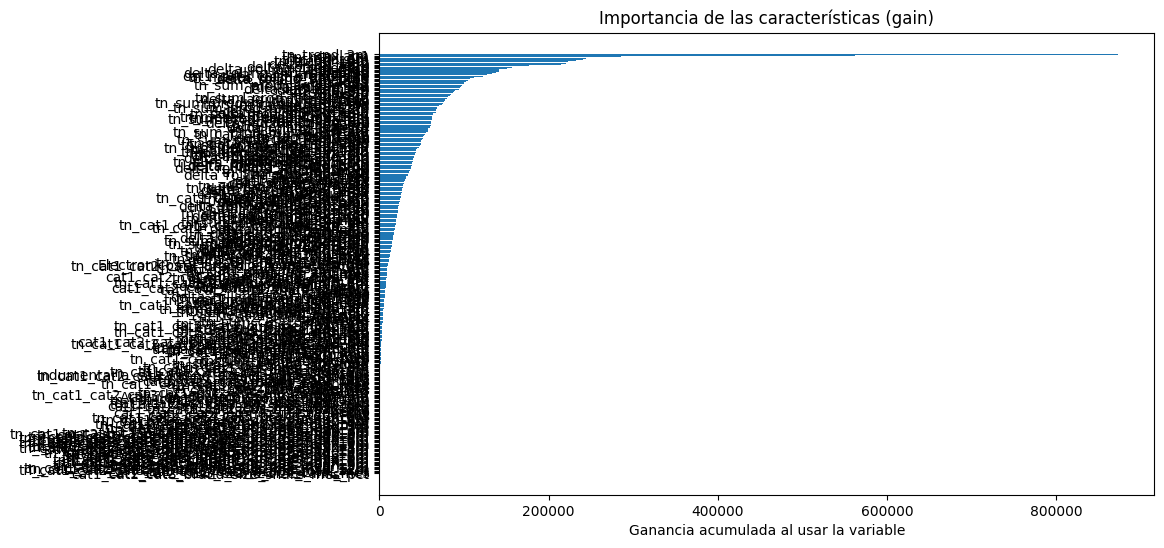

In [22]:
plt.figure(figsize=(10,6))
plt.barh(df_importances['feature'], df_importances['importance_gain'])
plt.xlabel('Ganancia acumulada al usar la variable')
plt.title('Importancia de las características (gain)')
plt.gca().invert_yaxis()
plt.show()

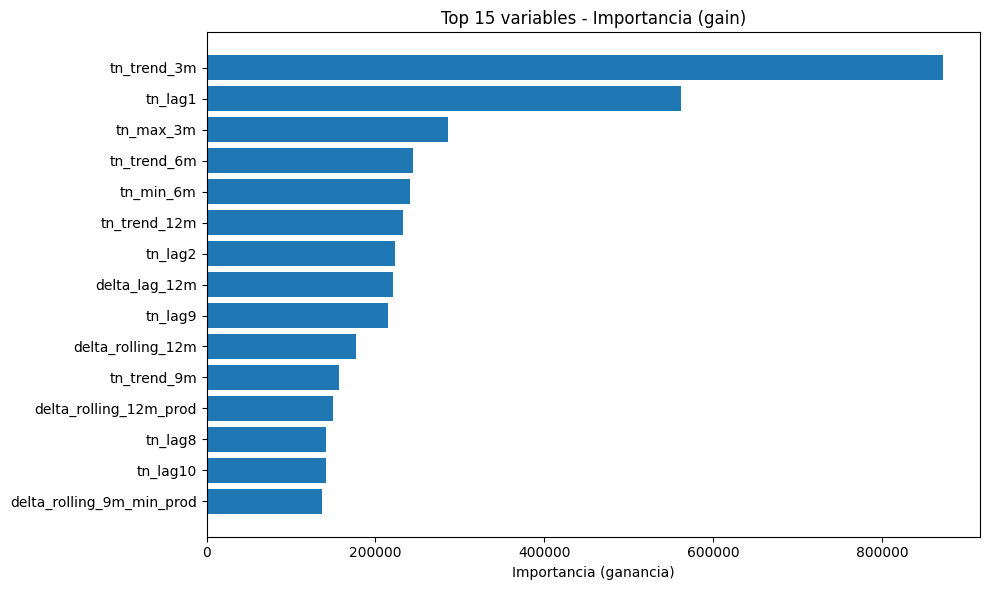

In [23]:
top = df_importances.sort_values('importance_gain', ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top['feature'][::-1], top['importance_gain'][::-1])  # Invierte para mayor arriba
plt.xlabel('Importancia (ganancia)')
plt.title('Top 15 variables - Importancia (gain)')
plt.tight_layout()
plt.show()

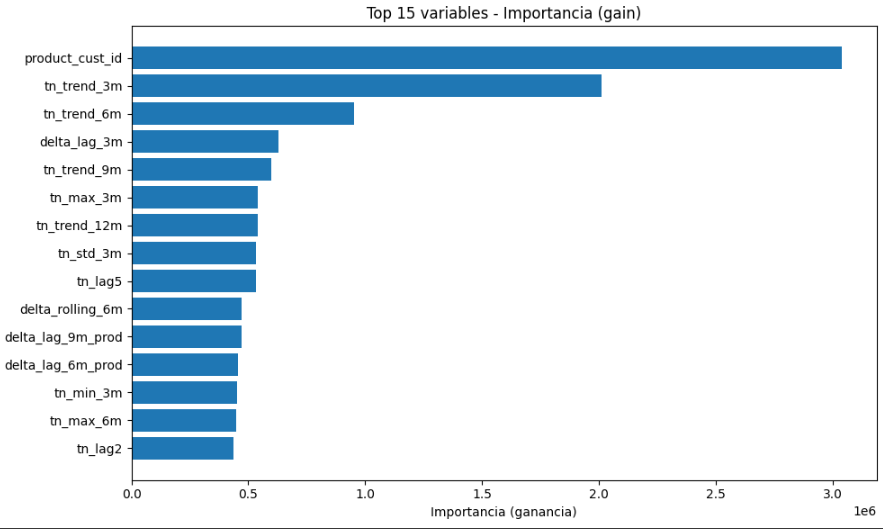

In [24]:
df_36 = df_cluster_X[df_cluster_X['date_mes'] == '2019-12'].copy()

# Escalar solo num_cols
for col in num_cols:
    tipo, val = scalers[col]
    if tipo == 'std':
        df_36[col] = df_36[col] / val
    elif tipo == 'mean':
        df_36[col] = df_36[col] / val
    # else: no escala

In [25]:
# Label encoding para categóricas (manejar categorías nuevas con cuidado)
for col in categorical_cols:
    le = le_dict[col]
    vals = df_36[col].astype(str).fillna('missing')
    # Si aparecen categorías nuevas, las convertimos a -1 para evitar error
    df_36[col] = vals.map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

X_36 = df_36[num_cols + categorical_cols]

In [26]:
X_36.shape

(7514, 326)

In [27]:
# Predecimos la diferencia tn_38 - tn_36
pred_diff = gbm_final.predict(X_36)

# Reconstruimos la predicción absoluta para mes 38
df_36['tn_pred_38'] = df_36['tn'] + pred_diff

# Mostrar resultados
print(df_36[['product_cust_id', 'tn', 'tn_pred_38']].head())

      product_cust_id       tn  tn_pred_38
7371      20001_10002  113.332      69.361
23413     20001_10017    0.000       6.168
28679     20001_10019   17.744      19.428
32646     20001_10021   30.806     -22.127
36255     20001_10022   31.052      -0.195


/tmp/ipython-input-27-1009334013.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_36['tn_pred_38'] = df_36['tn'] + pred_diff


In [28]:
df_result = df_36[['product_cust_id', 'tn_pred_38']].copy()
df_result.head()

,product_cust_id,tn_pred_38
7371,20001_10002,69.361
23413,20001_10017,6.168
28679,20001_10019,19.428
32646,20001_10021,-22.127
36255,20001_10022,-0.195


In [29]:
df_historia.head()

,product_cust_id,min
0,20001_10002,0.762
1,20001_10017,0.751
2,20001_10019,0.616
3,20001_10021,0.369
4,20001_10022,0.739


In [30]:
df_37= df_36.copy()
df_37.shape

(7514, 338)

In [31]:
SEEDS = [17,53,101,199,281,397,503,619,733,853,967,1087,1223,1361,1489]
#SEEDS = [17]

for current_seed in SEEDS:
    final_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': current_seed,
    })

    lgb_full = lgb.Dataset(X, label=y, categorical_feature=categorical_cols)
    gbm_final = lgb.train(
        final_params,
        lgb_full,
        num_boost_round=1000,
        #verbose_eval=100
    )
    # Predecimos la diferencia tn_38 - tn_36
    pred_diff = gbm_final.predict(X_36)
    df_temp = pd.DataFrame()
    seed_str=str(current_seed)
    df_37['tn_seed_'+ seed_str] = df_36['tn'] + pred_diff


print(df_37.shape)

(7514, 353)


In [32]:
df_result_seeds = df_37[['product_cust_id', 'tn_pred_38','tn_seed_17','tn_seed_53','tn_seed_101','tn_seed_199','tn_seed_281','tn_seed_397','tn_seed_503','tn_seed_619','tn_seed_733','tn_seed_853','tn_seed_967','tn_seed_1087','tn_seed_1223','tn_seed_1361','tn_seed_1489']].copy()
df_result_seeds.head()

,product_cust_id,tn_pred_38,tn_seed_17,tn_seed_53,tn_seed_101,tn_seed_199,tn_seed_281,tn_seed_397,tn_seed_503,tn_seed_619,tn_seed_733,tn_seed_853,tn_seed_967,tn_seed_1087,tn_seed_1223,tn_seed_1361,tn_seed_1489
7371,20001_10002,69.361,62.423,70.877,63.256,75.633,43.984,75.814,65.034,72.446,49.822,69.409,67.079,62.181,58.212,47.418,74.037
23413,20001_10017,6.168,11.161,6.688,-3.701,13.003,-4.936,11.654,-3.208,4.502,0.705,7.490,13.838,10.314,7.163,6.515,8.906
28679,20001_10019,19.428,11.003,8.503,12.537,20.916,12.314,20.387,15.891,16.228,10.419,2.889,14.805,15.016,15.581,12.203,5.611
32646,20001_10021,-22.127,-21.176,-34.869,-40.437,-32.725,-35.909,-16.663,-37.751,-21.864,-35.572,-25.448,-28.007,-31.258,-33.470,-43.283,-32.832
36255,20001_10022,-0.195,-1.266,-4.580,-14.929,0.298,-9.688,3.472,-8.435,-4.120,-4.459,-2.522,-4.068,-9.843,-7.842,-8.739,-7.933


In [33]:
# 1. Detectar la(s) columna(s) tipo string (object); asumir que solo hay una
str_cols = df_result_seeds.select_dtypes(include='object').columns.tolist()  # Ej: ['nombre']

# 2. Detectar las columnas numéricas
num_cols = df_result_seeds.select_dtypes(include='number').columns.tolist()  # Ej: ['valor1', 'valor2', 'valor3']

# 3. Calcular el promedio de las columnas numéricas por fila y crear la columna 'tn'
df_result_seeds['tn'] = df_result_seeds[num_cols].mean(axis=1)

# 4. Dejar solo la columna string y la columna 'tn'
df_sem = df_result_seeds[str_cols + ['tn']]

# Ahora tu DataFrame se ve así:
#   nombre   tn
# 0    Ana  4.0
# 1   Luis  5.0
# 2    Eva  6.0

# Opcional: imprime el resultado
print(df_sem.head())

      product_cust_id      tn
7371      20001_10002  64.187
23413     20001_10017   6.016
28679     20001_10019  13.358
32646     20001_10021 -30.837
36255     20001_10022  -5.303


In [34]:
# es muy raro que el mismo comprador compre menos de lo que ha comprado, y mucho menos puede comprar negativo
# Unimos ambos DataFrames usando product_cust_id como llave
df_result_1 = pd.merge(df_sem, df_historia[['product_cust_id', 'min']], on='product_cust_id', how='inner')

# Definimos la función para calcular el forecast según las reglas dadas
def calcular_forecast(row):
    tn_pred = row['tn']
    min_val = row['min']
    if tn_pred > min_val:
        return tn_pred
    elif tn_pred > (min_val / 2) and tn_pred <= min_val:
        return min_val
    else:
        return 0

# Aplicamos la función para calcular la nueva columna 'forecast'
df_result_1['forecast'] = df_result_1.apply(calcular_forecast, axis=1)

# Si solo quieres quedarte con product_cust_id y forecast:
df_result_1 = df_result_1[['product_cust_id', 'forecast']]

In [ ]:
df_result_1.head()

,product_cust_id,forecast
0,20001_10002,69.361
1,20001_10017,6.168
2,20001_10019,19.428
3,20001_10021,0.000
4,20001_10022,0.000


In [35]:
df_result_1.shape

(7514, 2)

In [36]:
# Crear nueva columna 'product_id' tomando los primeros 5 caracteres de 'product_cust_id'
df_result_1['product_id'] = df_result_1['product_cust_id'].str[:5]

# Agrupar por 'product_id' y sumarizar la columna 'forecast' en una nueva columna 'forecast_plus'
df_summary = df_result_1.groupby('product_id', as_index=False)['forecast'].sum()

# Renombrar la columna resultante para que se llame 'forecast_plus'
df_summary = df_summary.rename(columns={'forecast': 'forecast_plus'})

# Mostrar el resultado
print(df_summary.head())

  product_id  forecast_plus
0      20001        127.488
1      20002        631.827
2      20003        149.953
3      20004        135.400
4      20005        200.548


In [37]:
df_summary['product_id']=df_summary['product_id'].astype(int)

In [38]:
# Merge para obtener el promedio solo para los product_id que están en productos_validar
df_validar = productos_validar.merge(
    df_summary,
    on='product_id',
    how='left'
)

# Ahora df_validar_promedio tendrá dos columnas: product_id y tn_prom_2018
print(df_validar.head())

   product_id  forecast_plus
0       20001        127.488
1       20002        631.827
2       20003        149.953
3       20004        135.400
4       20005        200.548


In [39]:
# le cambio el nombre de mean a tn
df_validar.rename(columns={'forecast_plus': 'tn'}, inplace=True)
df_validar.head()

,product_id,tn
0,20001,127.488
1,20002,631.827
2,20003,149.953
3,20004,135.400
4,20005,200.548


In [40]:
df_validar.to_csv(DATOS_DIR +'df_cluster1_lgbm_V3.csv', index=False)